In [24]:
import os
import pandas as pd


def identify_COPD(id_sheet):
    df = pd.read_csv(id_sheet, engine='python')
    copd_patients = df[df['Diagnosis'] == 'COPD']
    return copd_patients

path = "/Users/saada/Desktop/Digibiomics/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis_3.csv"

identify_COPD(path).head()

def identify_non_COPD(id_sheet):
    df = pd.read_csv(id_sheet, engine='python')
    non_copd_patients = df[df['Diagnosis'] != 'COPD']
    return non_copd_patients

In [25]:
import os
import shutil

source_folder = "/Users/saada/Desktop/Digibiomics/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files"
destination_folder = "/Users/saada/Desktop/Digibiomics/Respiratory_Sound_Database/Respiratory_Sound_Database/Positive_COPD"
negative_folder = "/Users/saada/Desktop/Digibiomics/Respiratory_Sound_Database/Respiratory_Sound_Database/Negative_COPD"

# Copy files for COPD patients
for _, row in identify_COPD(path).iterrows():
    patient_id = str(row['ID'])[:3]

    # Loop through all files in the source directory
    for file in os.listdir(source_folder):
        if file.endswith('.wav') and file[:3] == patient_id:
            source_path = os.path.join(source_folder, file)
            dest_path = os.path.join(destination_folder, file)
            shutil.copy(source_path, dest_path)


# Copy files for non-COPD patients
for _, row in identify_non_COPD(path).iterrows():
    patient_id = str(row['ID'])[:3]

    # Loop through all files in the source directory
    for file in os.listdir(source_folder):
        if file.endswith('.wav') and file[:3] == patient_id:
            source_path = os.path.join(source_folder, file)
            dest_path = os.path.join(negative_folder, file)
            shutil.copy(source_path, dest_path)

In [26]:
import os
import librosa
import numpy as np

def get_durations(folder_path):
    durations = []

    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            file_path = os.path.join(folder_path, file)
            try:
                y, sr = librosa.load(file_path, sr=None)  # keep original sampling rate
                duration = librosa.get_duration(y=y, sr=sr)
                durations.append(duration)
            except Exception as e:
                print(f"Could not process {file}: {e}")

    return durations

# Folders
positive_folder = "/Users/saada/Desktop/Digibiomics/Respiratory_Sound_Database/Respiratory_Sound_Database/Positive_COPD"
negative_folder = "/Users/saada/Desktop/Digibiomics/Respiratory_Sound_Database/Respiratory_Sound_Database/Negative_COPD"

# Get durations
positive_durations = get_durations(positive_folder)
negative_durations = get_durations(negative_folder)

# Compute stats
print("Positive audio:")
print(f"Average duration: {np.mean(positive_durations):.2f} seconds")
print(f"Median duration: {np.median(positive_durations):.2f} seconds\n")

print("Negative audio:")
print(f"Average duration: {np.mean(negative_durations):.2f} seconds")
print(f"Median duration: {np.median(negative_durations):.2f} seconds")


Positive audio:
Average duration: 21.73 seconds
Median duration: 20.00 seconds

Negative audio:
Average duration: 19.99 seconds
Median duration: 20.00 seconds


In [42]:
# Constants
SAMPLE_RATE = 16000
DURATION = 20  # in seconds
N_SAMPLES = SAMPLE_RATE * DURATION
N_MELS = 128

def center_crop_audio(y, target_len):
    if len(y) < target_len:
        # Pad evenly on both sides
        pad_amount = target_len - len(y)
        left_pad = pad_amount // 2
        right_pad = pad_amount - left_pad
        y = np.pad(y, (left_pad, right_pad), mode='constant')
    else:
        # Crop from the middle
        start = (len(y) - target_len) // 2
        y = y[start:start + target_len]
    return y

def center_crop_audio(audio, n_samples):
    if len(audio) < n_samples:
        padding = n_samples - len(audio)
        audio = np.pad(audio, (padding // 2, padding - padding // 2))
    elif len(audio) > n_samples:
        start = (len(audio) - n_samples) // 2
        audio = audio[start:start + n_samples]
    return audio

def folder_to_melspecs(folder_path, label):
    X = []
    y = []
    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            file_path = os.path.join(folder_path, file)
            signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            signal = center_crop_audio(signal, N_SAMPLES)

            mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=N_MELS)
            log_mel = librosa.power_to_db(mel, ref=np.max)

            log_mel -= log_mel.min()
            log_mel /= log_mel.max()

            X.append(log_mel)
            y.append(label)
    return X, y

def load_melspectrogram_data_from_wav(pos_dir, neg_dir):
    X_pos, y_pos = folder_to_melspecs(pos_dir, label=1)
    X_neg, y_neg = folder_to_melspecs(neg_dir, label=0)

    X = np.array(X_pos + X_neg)
    y = np.array(y_pos + y_neg)

    return X, y

    

In [48]:
from sklearn.model_selection import train_test_split

X, y = load_melspectrogram_data_from_wav("/Users/saada/Desktop/Digibiomics/Respiratory_Sound_Database/Respiratory_Sound_Database/Positive_COPD", "/Users/saada/Desktop/Digibiomics/Respiratory_Sound_Database/Respiratory_Sound_Database/Negative_COPD")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



In [49]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = X_train.shape[1:]  # e.g., (128, 431)

model = models.Sequential([
    layers.Input(shape=input_shape + (1,)),  # Add channel dimension
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 624, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 312, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 310, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 155, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 153, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 76, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 136192)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     8,716,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,809,089 (33.60 MB)

 Trainable params: 8,809,089 (33.60 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
from sklearn.utils import class_weight
import numpy as np

# Example labels array
y = np.array([1] * 794 + [0] * 128)  # 794 positives, 128 negatives

# Compute class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

# Map to dictionary format for TensorFlow
class_weight_dict = {0: weights[0], 1: weights[1]}
print(class_weight_dict)


{0: 3.6015625, 1: 0.5806045340050378}


In [51]:
# Add a channel dimension if needed
X_train_exp = np.expand_dims(X_train, -1)
X_val_exp = np.expand_dims(X_val, -1)

history = model.fit(
    X_train_exp, y_train,
    validation_data=(X_val_exp, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weight_dict
)


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 551ms/step - accuracy: 0.7400 - loss: 0.5916 - val_accuracy: 0.2174 - val_loss: 0.9965
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 535ms/step - accuracy: 0.5081 - loss: 0.6418 - val_accuracy: 0.6087 - val_loss: 0.5522
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 544ms/step - accuracy: 0.6751 - loss: 0.5725 - val_accuracy: 0.6196 - val_loss: 0.5552
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 552ms/step - accuracy: 0.6611 - loss: 0.5723 - val_accuracy: 0.5815 - val_loss: 0.5585
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 566ms/step - accuracy: 0.6953 - loss: 0.5712 - val_accuracy: 0.3967 - val_loss: 0.9618
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 576ms/step - accuracy: 0.6622 - loss: 0.5266 - val_accuracy: 0.8043 - val_loss: 0.3923
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 582ms/step - accuracy: 0.7898 - loss: 0.4298 - val_accuracy: 0.7283 - val_loss: 0.4854
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 753ms/step - accuracy: 0.8041 - loss: 0.4300 - val_accu

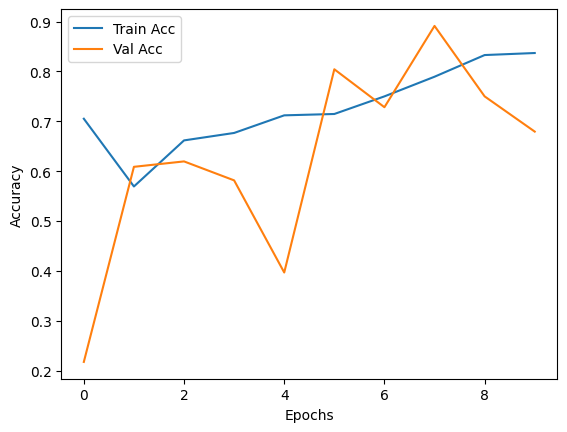

In [52]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
Accuracy: 0.6793
F1 Score: 0.7739
Confusion Matrix:
[[ 24   1]
 [ 58 101]]


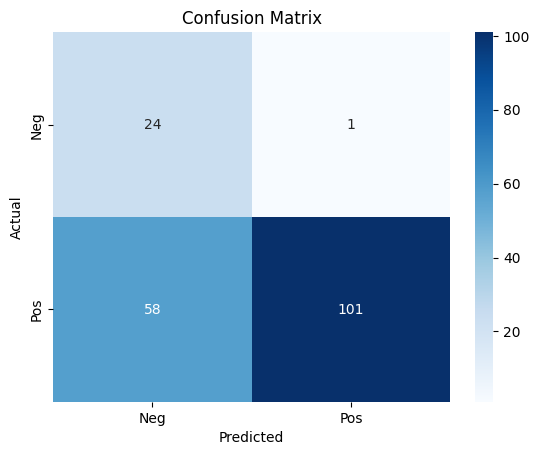

Classification Report:
              precision    recall  f1-score   support

    Negative       0.29      0.96      0.45        25
    Positive       0.99      0.64      0.77       159

    accuracy                           0.68       184
   macro avg       0.64      0.80      0.61       184
weighted avg       0.90      0.68      0.73       184



In [55]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on validation set
y_pred_prob = model.predict(X_val_exp)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.4f}")

# F1 Score (harmonic mean of precision and recall)
f1 = f1_score(y_val, y_pred)
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

# Optional: Pretty Confusion Matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Full Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=['Negative', 'Positive']))
